In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from apyori import apriori

## Подготовка данных

In [2]:
# Функция загрузки и подготовки данных
def load_data(filename):
    """
    Загружает данные из .CSV файла и преобразует их в список транзакций.
    
    :params:
    filename -- имя CSV-файла с покупками (товары в строке через запятую)
    
    :returns:
    transactions -- список списков (каждый внутренний список - это покупка)
    """
    # Читаем CSV, разделитель — запятая, без заголовков
    data = pd.read_csv(filename, header=None)
    
    # Преобразуем строки в списки товаров
    transactions = data.apply(lambda row: [item.strip() for item in row.dropna()], axis=1).tolist()
    
    return transactions


In [3]:
# Загружаем данные
data_path = "./data/baskets.csv"
transactions = load_data(data_path)
print(f"Загружено {len(transactions)} транзакций. Пример данных:")
for transaction in transactions[:5]:
    print(transaction)

Загружено 7501 транзакций. Пример данных:
['креветки', 'миндаль', 'авокадо', 'овощная смесь', 'зеленый виноград', 'цельнозерновая мука', 'батат', 'творог', 'энергетический напиток', 'томатный сок', 'низкокалорийный йогурт', 'зеленый чай', 'мед', 'салат', 'минеральная вода', 'лосось', 'ягодный сок', 'замороженный смузи', 'шпинат', 'оливковое масло']
['гамбургер', 'фрикадельки', 'яйца']
['чатни']
['индейка', 'авокадо']
['минеральная вода', 'молоко', 'энергетический батончик', 'рис', 'зеленый чай']


## Поиск частых наборов

In [4]:
def run_apriori(transactions, min_support, sort_method = "support"):
    """
    Выполняет алгоритм Apriori с библиотекой apyori.
    
    :param:
    transactions -- список транзакций (списков товаров)
    min_support -- минимальный порог поддержки (в долях, например 0.05)
    
    :returns:
    DataFrame с найденными частыми наборами и их поддержкой
    """
    results = list(apriori(transactions, min_support=min_support))
    
    frequent_itemsets = [(tuple(result.items), result.support) for result in results]
    df = pd.DataFrame(frequent_itemsets, columns=["itemsets", "support"])
    
    # Сортируем по заданному критерию
    if sort_method == "support":
        df = df.sort_values(by="support", ascending=False)
    elif sort_method == "lexicographic":
        df = df.sort_values(by="itemsets", ascending=True)
        
    return df


In [5]:
execution_time = list()
length_distribution = dict()

for min_support_value in range(1, 15, 2):
    start_time = time.time()
    frequent_itemsets = run_apriori(transactions, min_support=min_support_value/100, sort_method = "support")
    execution_time.append(time.time()-start_time)
    
    length_counts = dict()
    
    for items in frequent_itemsets["itemsets"]:
        length = len(items)
        if length in length_counts:
            length_counts[length] += 1
        else:
            length_counts[length] = 1

    for length, count in length_counts.items():
        if length not in length_distribution:
            length_distribution[length] = []
        length_distribution[length].append((min_support_value, count))
    
    print(f"Пороговое значение поддержки {min_support_value:.0f}%: {frequent_itemsets.shape[0]} частых наборов")
    print(frequent_itemsets)

    print("-"*40)

Пороговое значение поддержки 1%: 261 частых наборов
                                         itemsets   support
31                            (минеральная вода,)  0.238368
26                                    (макароны,)  0.187975
73                                        (яйца,)  0.179709
20                               (картофель-фри,)  0.170911
69                                     (шоколад,)  0.163845
..                                            ...       ...
210                    (минеральная вода, хлопья)  0.010265
124                    (замороженные овощи, торт)  0.010265
120  (замороженные овощи, низкокалорийный йогурт)  0.010132
248        (говяжий фарш, минеральная вода, яйца)  0.010132
235                                (шоколад, суп)  0.010132

[261 rows x 2 columns]
----------------------------------------
Пороговое значение поддержки 3%: 55 частых наборов
                                  itemsets   support
14                     (минеральная вода,)  0.238368
12    

## Вывод графиков

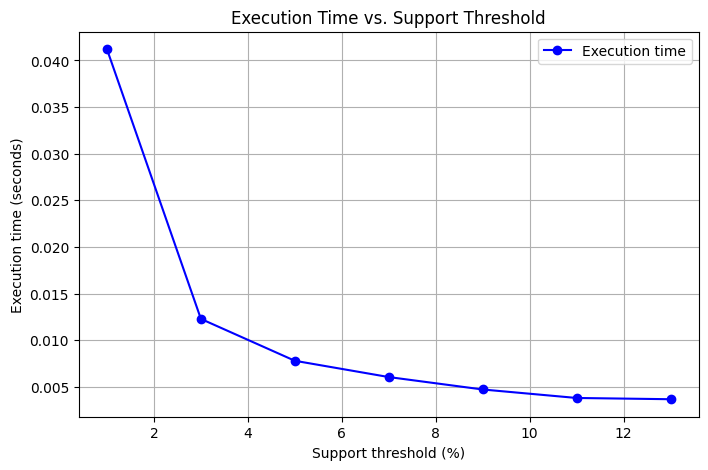

In [8]:
plt.figure(figsize=(8, 5))
plt.plot([s for s in range(1, 15, 2)], execution_time, marker="o", color="b", label="Execution time")
plt.xlabel("Support threshold (%)")
plt.ylabel("Execution time (seconds)")
plt.title("Execution Time vs. Support Threshold")
plt.legend()
plt.grid()
plt.show()

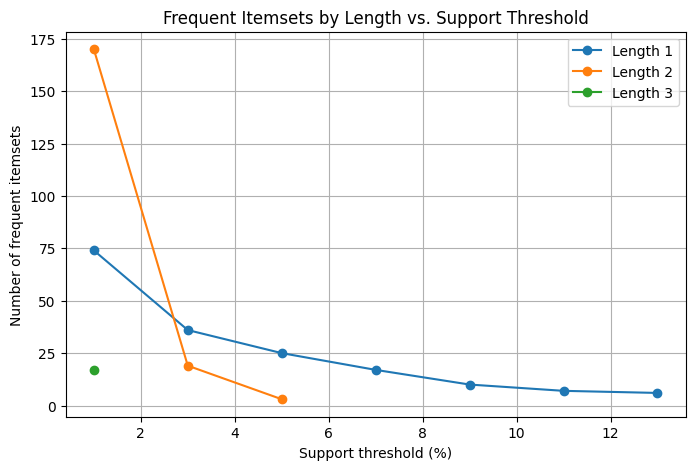

In [7]:
# Визуализируем данные
plt.figure(figsize=(8, 5))

for length in sorted(length_distribution.keys()):
    values = length_distribution[length]
    supports, counts = zip(*values)
    plt.plot([s for s in supports], counts, marker="o", label=f"Length {length}")

plt.xlabel("Support threshold (%)")
plt.ylabel("Number of frequent itemsets")
plt.title("Frequent Itemsets by Length vs. Support Threshold")
plt.legend()
plt.grid()
plt.show()